# Download json and summarize records for all published datasets

This should work for any socrata portal, but you'll need to adjust the custom values in the metadata completeness sections

Probably need to get a token to be able to download all the data.  Right now the API call specifies the number of assets so it still works. Otherwise it only returns 100

In [13]:
#import the required libraries
import os
import csv
import requests
import json as json
from pandas.io.json import json_normalize
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns


## Set up the code for your portal of interest

In [2]:
targeturl='https://data.wa.gov/' #change this to the SOCRATA portal you want to target, don't forget ending /
domain='data.wa.gov' 
descriptor='WA'   #change this to a recognizable descriptor for yourself- used in csv filename
downloadDate = datetime.datetime.now()

### Create Dictionary json records
Use the Socrata API to get ALL metadata for the public assets

add authentication?? ?$$app_token=OHlDzukOUa15bLYTvOV23hrmX

In [3]:
r=requests.get('http://api.us.socrata.com/api/catalog/v1?limit=2655&domains='+domain) #build string according to SOCRATA's convention to get public data assets
#r=requests.get('http://api.us.socrata.com/api/catalog/v1?domains='+domain) #build string according to SOCRATA's convention to get public data assets
j=json.loads(r.text) #parse the json into a list named j
j=[i for i in j['results']] #This gets rid of the 'results' key

### Save the json to a file so you don't have to keep downloading it everytime.

In [41]:
#j[0] #view the first record
with open("fullWA"+str(datetime.datetime.now().strftime("%Y-%m-%d"))+".json", "w") as write_file:
    json.dump(j, write_file)

### Open the csv file with testing data

In [3]:
#Open up the same file for reading
with open("fullWA2019-07-26.json", "r") as read_file:
    dtest = json.load(read_file)

In [4]:
# Using list comprehension to delete dictionary in list that contains 'reportcard'. If you want the full dataset, rerun the above script and change 'dtest' to 'd'.
# All scripts below use 'd' as the source data
d = [i for i in dtest if 'reportcard' not in (i['classification']['domain_tags'])]
len(d)

2230

### Test Pit

Ignore this block.  Use it to test out things or store bits of unused code

In [49]:
#The indexes for i (below) are much more limited than the indexes for j
#test=[] #test list to fill

#for c in d:
#    #for x in c:
#        if c.get('format') == 'text/csv':
#            t = c.get('identifier')
#            test.append(t)
#            #print(c.get('format'))
#test.sort()
#print(test[0:20])


#print(len(test))
#j['results'][0]['resource'].keys() #Shows keys
#type(j['identifier'])
#print(j[0]['format'])
#print(j['results'][0]['resource']['type'])
#df = pd.DataFrame(j['']) 

#create a dataframe of the whole dataset (normalize deals with the nested structure)
#df = pd.DataFrame.from_dict(json_normalize(d['results']), orient='columns')

d['classification']['domain_tags']

dataset


## Look at Types of Assets and Categories

### Types for All Assets

In [5]:
#Set up a list of all the types

typelist=[] #dim list as a empty list

for c in d:  #d is the dictionary of parsed json
        if len(c['resource']['id'])==9: #Basically, is the identifier legitimate?
            typelist.append(c['resource']['type'])

print("List built:", len(typelist),"elements") #print how many elements are in dtlist


List built: 2230 elements


In [8]:
#Convert the dictionary to a dataframe
dftype = pd.DataFrame(typelist, columns=['type'])
dftype.head()

,type
0,dataset
1,map
2,map
3,dataset
4,dataset


Text(0, 0.5, '')

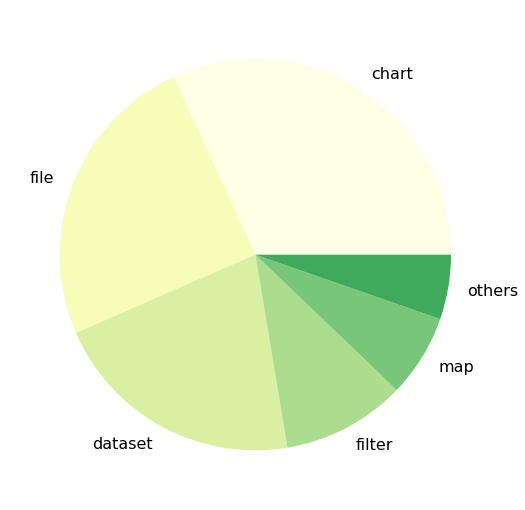

In [101]:
#Create a pie chart

pltdf = dftype.type.value_counts() #uses matlibplot to count rows for each type

pltdftype = pd.DataFrame({'descriptor':'assetTypes','unit':pltdf.index, 'value':pltdf.values}) #Converts the series to a dataframe and adds a column for the longitudinal dataset
pltdftype.sort_values(by=['value'], ascending=False)
pltdf2 = pltdftype[:5].copy() #Put top 5 types in a new dataframe


# Takes the less common types and adds those counts into a value named others.
new_row = pd.DataFrame(data = {
    'unit' : ['others'],
    'value' : [pltdftype['value'][5:].sum()]
})


pltdf2 = pd.concat([pltdf2, new_row], sort=True) #Add the 'others' value to the top 5 dataframe

#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html
#https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html
#http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot


#plot the types
cs=cm.YlGn(np.arange(6)/8.)
pltdf2.plot(y='value', kind='pie', labels=pltdf2.unit, colors=cs, legend=False, textprops={'fontsize': 16})
plt.ylabel('') #Gets rid of the "Counts label"

### Dataframe of proportions

In [16]:
dftypep = dftype.type.value_counts()
dftypep = dftypep.to_frame()
dftypep['percent'] = dftypep.type / dftypep.type.sum()
print(dftypep)

                type   percent
chart            710  0.318386
file             551  0.247085
dataset          470  0.210762
filter           228  0.102242
map              152  0.068161
federated_href    39  0.017489
href              30  0.013453
datalens          23  0.010314
form              12  0.005381
story              9  0.004036
visualization      4  0.001794
calendar           2  0.000897


### Categories for All Assets

In [17]:
#Set up a list of all the types

catlist=[] #dim masterlist as a empty list

for i in d:  #d is the dictionary of parsed json
        if len(i['resource']['id'])==9: #Basically, is the identifier legitimate?
            catlist.append(i['classification'].get('domain_category', 'No Value'))


catlist.sort()
print("List built:", len(catlist),"elements") #print how many elements are in dtlist

List built: 2230 elements


In [18]:
#Convert the list to a dataframe
dfcat = pd.DataFrame(catlist, columns = ['category'])
dfcat.head()

,category
0,Agriculture
1,Consumer Protection
2,Consumer Protection
3,Consumer Protection
4,Consumer Protection


Text(0, 0.5, '')

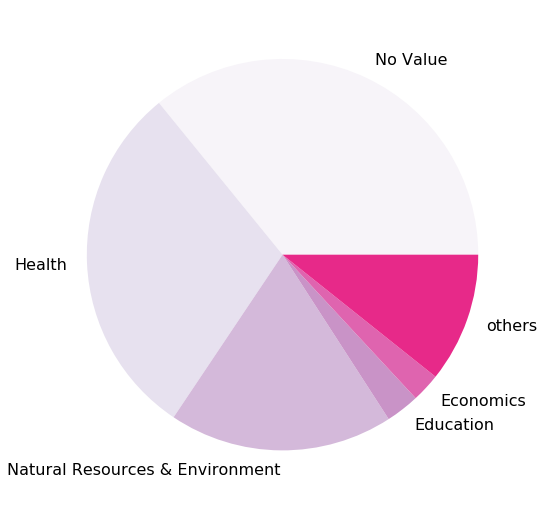

In [100]:
#Create a pie chart

pltdf = dfcat.category.value_counts() #uses matlibplot to count rows for each type

pltdfcat = pd.DataFrame({'descriptor':'assetCategories','unit':pltdf.index, 'value':pltdf.values}) #Converts the series to a dataframe

pltdf2 = pltdfcat[:5].copy() #Put top 5 types in a new dataframe


# Takes the less common types and adds those counts into a value named others.
new_row = pd.DataFrame(data = {
    'unit' : ['others'],
    'value' : [pltdfcat['value'][5:].sum()]
})


pltdf2 = pd.concat([pltdf2, new_row], sort=False) #Add the 'others' value to the top 5 dataframe

#https://matplotlib.org/gallery/pie_and_polar_charts/pie_and_donut_labels.html
#https://matplotlib.org/3.1.1/tutorials/introductory/pyplot.html
#http://queirozf.com/entries/pandas-dataframe-plot-examples-with-matplotlib-pyplot


#plot the types
cs=cm.PuRd(np.arange(6)/8.)
pltdf2.plot(y='value', kind='pie', colors=cs, labels=pltdf2.unit, legend=False, textprops={'fontsize': 16})
plt.ylabel('') #Gets rid of the "Counts label"

### Dataframe of proportions

In [23]:
dfcatp = dfcat.category.value_counts()
dfcatp = dfcatp.to_frame()
dfcatp['percent'] = dfcatp.category / dfcatp.category.sum()
print(dfcatp)

                                 category   percent
No Value                              800  0.358744
Health                                663  0.297309
Natural Resources & Environment       413  0.185202
Education                              62  0.027803
Economics                              53  0.023767
Demographics                           47  0.021076
Public Safety                          41  0.018386
Politics                               35  0.015695
Procurements and Contracts             33  0.014798
Labor                                  32  0.014350
Consumer Protection                    26  0.011659
Transportation                         10  0.004484
Recreation                              8  0.003587
Employment                              6  0.002691
Agriculture                             1  0.000448


## Downloads and Views

In [24]:
downl = []
views=[]

for i in d:  #d is the dictionary of parsed json
        if len(i['resource']['id'])==9: #Basically, is the identifier legitimate?
            downl.append(i['resource']['download_count'])

for i in d:  #d is the dictionary of parsed json
        if len(i['resource']['id'])==9: #Basically, is the identifier legitimate?
            views.append(i['resource']['page_views']['page_views_total'])  

print("List built:", len(downl),"download counts") #print how many elements are in dtlist
print("List built:", len(views),"view counts") #print how many elements are in dtlist            

dfuse = pd.DataFrame([downl,views,typelist]).T #build a dataframe with both lists and the category list
dfuse.columns =['downloads','pageviews','type']


List built: 2230 download counts
List built: 2230 view counts


### Plot the values

Text(0.5, 0.98, '')

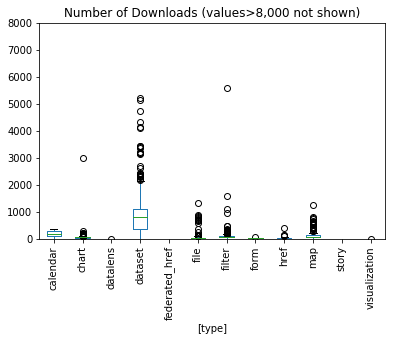

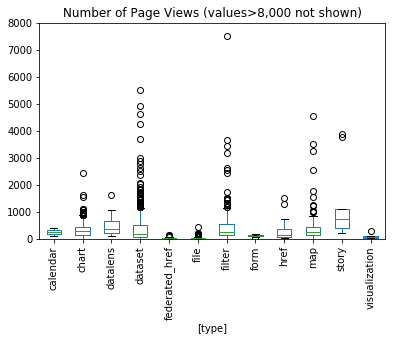

In [25]:
dfuse.boxplot(by = ['type'], column=['downloads'], grid=False)
plt.ylim(0,8000)
plt.xticks(rotation=90)
plt.title('Number of Downloads (values>8,000 not shown)')
plt.suptitle("")

dfuse.boxplot(by = ['type'], column=['pageviews'], grid=False)
plt.ylim(0,8000)
plt.xticks(rotation=90)
plt.title('Number of Page Views (values>8,000 not shown)')
plt.suptitle("")

### downloads vs views

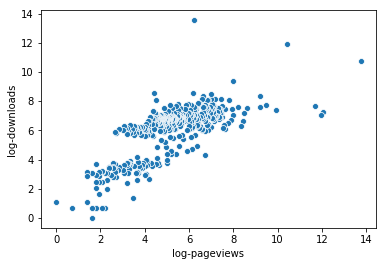

In [26]:
#Calculate logs for downloads and views, only use where use is greater than 0
dfusenum = dfuse[dfuse['type']=='dataset']
dfusenum = dfusenum[dfusenum.downloads > 0]
dfusenum['downloads'] = pd.to_numeric(dfusenum['downloads'])
dfusenum['pageviews'] = pd.to_numeric(dfusenum['pageviews'])
#dfusedataset = dfusenum[dfusenum['type']=='dataset']
#dfusedataset = dfusenum[dfusenum.downloads > 0]
dfusedataset = dfusenum  #I'm sure there is a way cleaner way to do this...
dfusedataset['log-pageviews'] = np.log(dfusenum.pageviews)
dfusedataset['log-downloads'] = np.log(dfusenum.downloads)
sns.scatterplot('log-pageviews', # Horizontal axis
           'log-downloads', # Vertical axis
           data=dfusedataset)



## Assess completion of available metadata elements
The API json does not include the custom metadatafields (or at least I could not figure out how to get them).  The script below downloads detailed metadata for a list of datasets retrieved from the discovery API. 

### Get list of dataset ids

In [28]:
dtlist=[] #dim list as a empty list

for c in d:  #d is the dictionary of parsed json
        if len(c['resource']['id'])==9: #Basically, is the identifier legitimate?
            if c['resource']['type'] == 'dataset':
                dtlist.append(c['resource']['id'])

print("List built:", len(dtlist),"elements") #print how many elements are in dtlist


List built: 470 elements


### Download metadata for each id and create both a csv file and then a dataframe

In [29]:
# Create a csv file and dataframe

#This function deals with multiply nested json elements in the csv write line below
#https://stackoverflow.com/questions/43491287/elegant-way-to-check-if-a-nested-key-exists-in-a-python-dict
def exists(obj, chain):
    _key = chain.pop(0)
    if _key in obj:
        return exists(obj[_key], chain) if chain else obj[_key]


metadata=open(descriptor+'-METADATA'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv', 'w', newline='')
csv.writer(metadata).writerow(['id','name','description','category','attribution','periodOfTime','postingFreq','originator','link','downloadCount','viewCount','licenseId','publicationDate','rowsUpdateAt','tags','rowLabel','metdataLanguage','numberColumns','numColumnDescriptions'])

for s in dtlist:
    s=requests.get(targeturl+'views/'+s+'.json?$$app_token=OHlDzukOUa15bLYTvOV23hrmX') #build string according to SOCRATA's convention
    r=json.loads(s.text)
    
    colnum = len(r['columns']) #Get number of columns
    
    count = 0
    for q in r['columns']:  #Tally the number of col descriptions that contain a description
        if q.get('description','') != '': #If the description key doesn't exist, default value is '' (don't know why some don't have the key)
            count += 1
    coldesc = count
    #write the values to the csv file. Dates in json files are seconds from jan 1 1970 so datetime.datetime.fromtimestamp converts
    #This has custom fields for data.wa.gov, to use with other portals, you'll have to customize it
    csv.writer(metadata).writerow([r['id'],
        r['name'],
        r.get('description','N/A'),
        r.get('category','N/A'),
        r.get('attribution','N/A'),
        exists(r['metadata'],['custom_fields','Temporal','Period of Time']), #See the function 'exists' above
        exists(r['metadata'],['custom_fields','Temporal','Posting Frequency']),
        exists(r['metadata'],['custom_fields','Identification','Originator']),
        r.get('attributionLink','N/A'),
        r['downloadCount'],
        r['viewCount'],
        r.get('LicenseID','N/A'),
        datetime.datetime.fromtimestamp(r['publicationDate']),
        datetime.datetime.fromtimestamp(r.get('rowsUpdatedAt','N/A')),
        r.get('tags','N/A'),
        r['metadata'].get('rowLabel','N/A'),
        exists(r['metadata'],['custom_fields','Identification','Metadata Language']),
        colnum,
        coldesc]) #write one line to csv file

metadata.close() #Close the output file, release all locks

#Open up the same file as a dataframe. Encode cp1252 avoids a utf8 error.
dfmeta = pd.read_csv(descriptor+'-METADATA'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv',encoding='cp1252')

32 of 32 rows written, 0 remaining


### How complete are available metadata elements?
'description','category','attribution','periodOfTime','postingFreq','originator','link','licenseId','tags','rowLabel', 'metadataLanguage'


In [35]:
#dfmeta.count(axis='columns')
#dfmeta.loc[446,]
dfmeta = pd.read_csv(descriptor+'-METADATA'+str(datetime.datetime.now().strftime("%Y-%m-%d"))+'.csv',encoding='cp1252')

Text(0.5, 0, 'Number of available metadata elements')

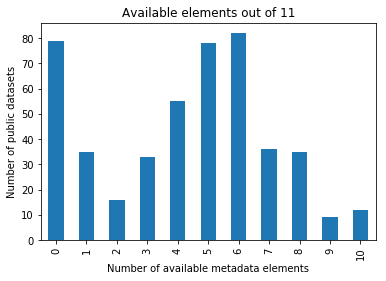

In [36]:
#Available metadata dataframe of public datasets
#dfmeta['numColumnDescriptions'].replace(0, np.nan, inplace = True)

#Count number of available metadata fields filled (not NaN)(and subtract the uid, name, downloads, views, pub date, update date, num columns, col desc)
adfmetas1 = dfmeta.count(axis='columns')-8

#Converts the series to a dataframe
adfmetacts = pd.DataFrame({'origIndex':adfmetas1.index, 'value':adfmetas1.values})

adfmetas2 = adfmetacts.value.value_counts() #uses matlibplot to count rows for each count

#Converts the series to a dataframe

adfmetacts = pd.DataFrame({'descriptor':'availableMetadataComplete','unit':adfmetas2.index, 'value':adfmetas2.values})
 

adfmeta = adfmetacts.sort_values('unit',ascending=True) #sort the rows

#plot the counts
adfmeta.plot(y='value', kind='bar', x='unit', legend=False, title='Available elements out of 11')
plt.ylabel('Number of public datasets') #Gets rid of the "Counts lable"
plt.xlabel('Number of available metadata elements')




### Create table of available metadata

In [80]:
adfmetarow = dfmeta.count('rows')

adfmetacts = pd.DataFrame({'origIndex':adfmetarow.index, 'value':adfmetarow.values}) #Converts the series to a dataframe

adfmetacts['percentYes'] = adfmetacts['value']/len(dfmeta) * 100 
adfmetacts['percentNo'] = 100 - adfmetacts['percentYes']

adfmetacts2 = adfmetacts.iloc[1:] #Get rid of id row

adfmetacts3 = adfmetacts2.sort_values('value',ascending=False) #sort the rows

adfmetacts3


,origIndex,value,percentYes,percentNo
1,name,470,100.000000,0.000000
9,downloadCount,470,100.000000,0.000000
17,numberColumns,470,100.000000,0.000000
13,rowsUpdateAt,470,100.000000,0.000000
12,publicationDate,470,100.000000,0.000000
10,viewCount,470,100.000000,0.000000
18,numColumnDescriptions,470,100.000000,0.000000
3,category,327,69.574468,30.425532
14,tags,323,68.723404,31.276596
2,description,311,66.170213,33.829787


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]), <a list of 18 Text xticklabel objects>)

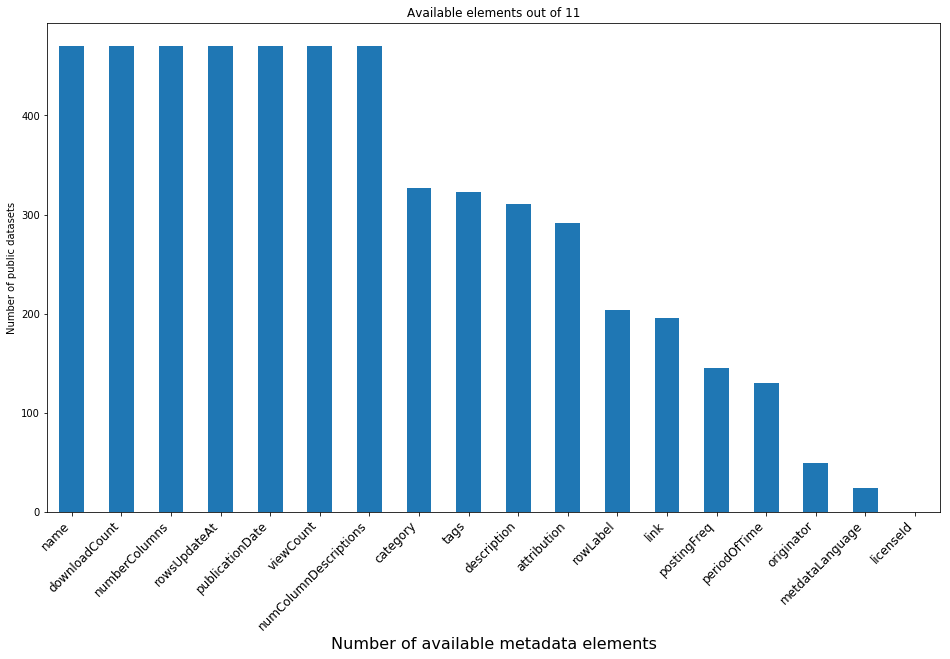

In [95]:
#plot the counts
plt.rcParams["figure.figsize"] = [16,9]
adfmetacts3.plot(y='value', kind='bar', x='origIndex', legend=False, title='Available elements out of 11')
plt.ylabel('Number of public datasets') #Gets rid of the "Counts lable"
plt.xlabel('Number of available metadata elements', fontsize=16)
#plt.rc('xtick', labelsize=12)
plt.xticks(rotation=45, fontsize=12, horizontalalignment='right')


### How complete are core metadata elements?
Description, Category, Posting Frequency, and Attribution (data_provided_by)

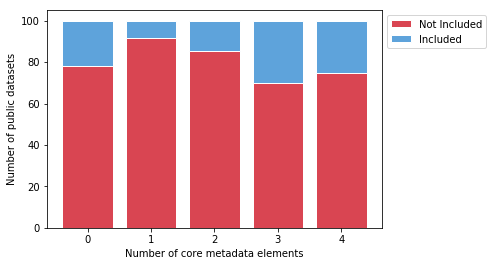

In [64]:
#Core Metadata DataFrame
cdfmetaorig = dfmeta[["id",
"description",
"category",
"postingFreq",
"attribution"]]

#Count number of core metadata elements filled (not NaN)(and subtract the uid)
cdfmetas1 = cdfmetaorig.count(axis='columns')-1

cdfmeta = pd.DataFrame({'origIndex':cdfmetas1.index, 'value':cdfmetas1.values}) #Converts the series to a dataframe

cdfmetas2 = cdfmeta.value.value_counts() #uses matlibplot to count rows for each count

cdfmetacts = pd.DataFrame({'descriptor':'coreMetadataComplete','unit':cdfmetas2.index, 'value':cdfmetas2.values}) #Converts the series to a dataframe
cdfmeta = cdfmetacts.sort_values('unit',ascending=True) #sort the rows

#Set up percent yes and no
cdfmeta['percentYes'] = cdfmeta['value']/len(dfmeta) * 100 
cdfmeta['percentNo'] = 100 - cdfmeta['percentYes']

#plot the counts
#cdfmeta.plot(y='value', kind='bar', x='unit', legend=False, title='Core elements out of 4')
# Create No bars
plt.bar(cdfmeta['unit'], cdfmeta['percentNo'], color='#d94552', edgecolor='white', label='Not Included')
# Create Yes bars
plt.bar(cdfmeta['unit'], cdfmeta['percentYes'], bottom=cdfmeta['percentNo'], color='#5ea3db', edgecolor='white', label='Included')


plt.ylabel('Percent public datasets') #Gets rid of the "Counts lable"
plt.xlabel('Number of core metadata elements')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

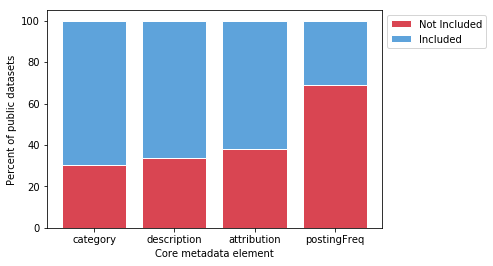

In [60]:
#Look at each core element
# Count the number of not null values for each column - Description, Category, Posting Frequency, and Attribution
coremeta = cdfmetaorig.count('rows')

coremeta1 = pd.DataFrame({'origIndex':coremeta.index, 'value':coremeta.values}) #Converts the series to a dataframe

coremeta1['percentYes'] = coremeta1['value']/len(dfmeta) * 100 
coremeta1['percentNo'] = 100 - coremeta1['percentYes']

coremeta2 = coremeta1.iloc[1:] #Get rid of id row

coremeta3 = coremeta2.sort_values('value',ascending=False) #sort the rows

#plot the counts
# Create No bars
plt.bar(coremeta3['origIndex'], coremeta3['percentNo'], color='#d94552', edgecolor='white', label='Not Included')
# Create Yes bars
plt.bar(coremeta3['origIndex'], coremeta3['percentYes'], bottom=coremeta3['percentNo'], color='#5ea3db', edgecolor='white', label='Included')

#coremeta3.plot(y='percentYes', kind='bar', x='origIndex', legend=False, title='Datasets with Completed Element')
#coremeta3.plot(y='percentNo', bottom='percentYes' kind='bar', x='origIndex', legend=False, title='Datasets with Completed Element')
plt.ylabel('Percent of public datasets') #Gets rid of the "Counts lable"
plt.xlabel('Core metadata element')
plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1)

In [65]:
cdfmeta.head()

,descriptor,unit,value,percentYes,percentNo
2,coreMetadataComplete,0,102,21.702128,78.297872
4,coreMetadataComplete,1,40,8.510638,91.489362
3,coreMetadataComplete,2,68,14.468085,85.531915
0,coreMetadataComplete,3,141,30.000000,70.000000
1,coreMetadataComplete,4,119,25.319149,74.680851


## Set up csv file to track values longitudinally

This csv file has four columns: download_date, descriptor, unit, value

An example entry would be: 2019-02-23, type, dataset, 509

Or: 2019-05-10, coremetadata-complete, 3, 208

In [62]:
#Calculate some summary stats
#calculate median
dfusestats = dfuse[dfuse['type']=='dataset']
med = dfusestats.median()
med = pd.DataFrame({'descriptor':'median','unit':med.index, 'value':med.values})

#calculate mean
mean = dfusestats.mean()
mean = pd.DataFrame({'descriptor':'mean','unit':mean.index, 'value':mean.values})

In [63]:
#Append dataframes to a new dataframe
long = pd.DataFrame(columns=['download_date','descriptor','unit','value'])
long = long.append([pltdftype, pltdfcat, adfmetacts, cdfmetacts, med, mean], sort=False, ignore_index = True)
long['download_date'] = downloadDate

In [64]:
#append data to csv file
if os.path.isfile('portalLog-noreportcard.csv'):
    long.to_csv('portalLog-noreportcard.csv', header=False, mode = 'a', index=False) #if file exists, append to it without header
else:
    long.to_csv('portalLog-noreportcard.csv', mode = 'w', index=False) #if file does not exist, create it and add header